In [1]:
%matplotlib inline

import pymysql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale

In [202]:
#Connect to the database
conn = pymysql.connect(host='104.196.5.55',
                             user='root',
                             db='nfl',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [214]:
#Create Offense dataframe with only WRs and relevant variables, create redzone dataframe

df_rb = pd.DataFrame(pd.read_sql('Select p.PNAME,o.PLAYER,RA,SRA,RY,TDR,REC,SNP,FP3,FUML,YEAR from offense o INNER JOIN player p on o.player = p.PLAYER WHERE p.POS1 = "'"RB"'"',conn,params=None))
#Create a merged dataframe with only WRs from 2015

#df_wrs.fillna(0,inplace=True)
df_rbs_2010 = df_rb[df_rb.YEAR == 2015]

#Use groupby to create a games count, average all fields used for analysis
rb_games = df_rbs_2010.groupby(['PNAME'])['RA'].count()
rbs = df_rbs_2010.groupby(['PNAME']).agg(np.mean)
rbs['games'] = rb_games

In this post, I will bring together two of my passions, Sports and Data. The use of data in sports has grown exponentially ovr the past few years, many professional teams now use data analytics in their game preparation. I want to start of with a pretty simple method, K-means clustering, that will help you group similar obeservations together. This can be used for any grouping you want to do, but I will be showing you what can be done with NFL data.

Data

The data I will use in the analysis is from Armchair Analysis. The dataset provides a level of granularity I have yet to see from the major sites like ESPN, NFL.com, or even pro-football-reference. The data is broken out into several tables (players, play-by-play, offense, etc.), which can be loaded into a database or consumed separately as csv files. I loaded the data into a google sql database and used python to query the database. For this exercise, I used the 'offense' table, which contains statistics for each offensive player for each game from 2000-2015. 

What is K-means clustering?

K-means clustering is a machine learning algorithm that is considered an unsupervised method -- there is no clear labeling of the observations, and our goal is to label them. The goal of clustering is to create clusters where each observation is as similar to each other as possible. This is done in 4 steps:

1. Start with a set of means
2. Assign each observation to a cluster that minimizes the distance to the center of the cluster.
3. Recompute the center using the observations in each cluster.
4. Repeat steps 2 and 3 until the cluster assignments don’t change.

My plan is to cluster running backs from 2015. This analysis is useful in finding replacement players, for example on bye weeks when fantasy football owners need to replace their player with a comparable player. I'll use the following variables: rushing attempts, successful rushing attempts (eliminates negative carries), touchdown receptions, receptions, snaps played, draftkings points, and fumbles.

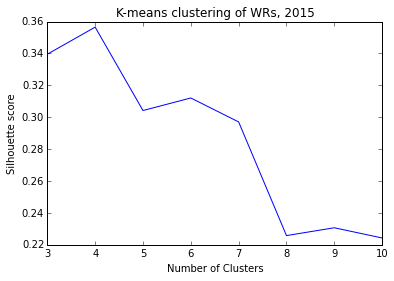

In [226]:
k = list(range(3,11))

scores = dict.fromkeys(k)

data = scale(rbs[['RA','SRA','RY','TDR','REC','SNP','FP3','FUML']].values)

for size in k:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(data)
    scores[size] = silhouette_score(data,kmeans.labels_)
    
plt.plot(k,scores.values())
plt.title('K-means clustering of WRs, 2015')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

In [228]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

clusters = pd.DataFrame(kmeans.cluster_centers_,
                       columns=['RA','SRA','RY','TDR','REC','SNP','FP3','FUML'])

rbs['cluster']=kmeans.labels_

In [229]:
clusters

,RA,SRA,RY,TDR,REC,SNP,FP3,FUML
0,0.229937,0.190822,0.191589,0.046210,0.273171,0.105684,0.207620,0.027968
1,1.662356,1.685422,1.683896,1.571171,0.981045,1.312849,1.624259,0.509762
2,-0.792730,-0.772984,-0.771005,-0.633212,-0.551449,-0.568511,-0.754631,-0.347084
3,-0.902162,-1.061019,-1.207907,-0.803845,-1.311270,-1.158571,-1.521223,9.964341


In [230]:
rbs[rbs.cluster==1]

,RA,SRA,RY,TDR,REC,SNP,FP3,FUML,YEAR,games,cluster
PNAME,,,,,,,,,,,
A.Bradshaw,12.591837,5.816327,53.918367,0.408163,2.612245,25.428571,14.130612,0.122449,2012.510204,49,1
A.Brown,11.210526,5.894737,46.157895,0.578947,1.736842,30.789474,11.394737,0.157895,2012.368421,19,1
A.Ellington,9.435897,3.820513,41.128205,0.230769,2.564103,29.615385,10.943590,0.076923,2013.923077,39,1
A.Foster,20.310345,9.137931,88.172414,0.689655,3.413793,36.327586,22.155172,0.137931,2012.534483,58,1
A.Morris,16.742424,7.787879,73.378788,0.439394,0.712121,35.712121,11.724242,0.106061,2013.500000,66,1
A.Peterson,20.131148,9.049180,98.967213,0.737705,2.000000,36.885246,19.011475,0.147541,2012.901639,61,1
B.Green-Ellis,14.153846,6.788462,53.115385,0.480769,0.769231,22.307692,9.751923,0.076923,2011.961538,52,1
C.Anderson,11.444444,5.083333,53.611111,0.416667,2.083333,33.000000,12.191667,0.055556,2014.416667,36,1
C.Benson,16.714286,7.952381,63.285714,0.380952,1.428571,9.476190,11.219048,0.095238,2011.238095,21,1
